In [109]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split


In [110]:
#load in model functions

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Define the layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 29)  # 29 output classes

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Activation function
        self.relu = nn.ReLU()

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def forward(self, x):
        # First convolution + pooling
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Second convolution + pooling
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # x = self.dropout(x)

        # Third convolution + pooling
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the output from the convolutional layers
        x = x.view(-1, 128 * 3 * 3)

        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Second fully connected layer (output layer)
        x = self.fc2(x)
        return x

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [111]:
# Load model and data
model = torch.load('trained_model.pth')
data_path = "./dataset/archive/"
test_df = pd.read_csv(data_path+'sign_mnist_test/sign_mnist_test.csv')
X = test_df.drop('label', axis=1).values  # Features - drops the label column and converts to numpy array
y = test_df['label'].values  # Labels
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

In [112]:
#basic data processing
test_images = test_df.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels = test_df['label'].values

test_ds = torch.from_numpy(test_images.reshape(test_images.shape[0],1,28,28))
test_label_ds = torch.from_numpy(test_labels)

test_ds = TensorDataset(test_ds, test_label_ds)
test_loader = DataLoader(dataset=test_ds, batch_size=32, shuffle=False, num_workers=4)

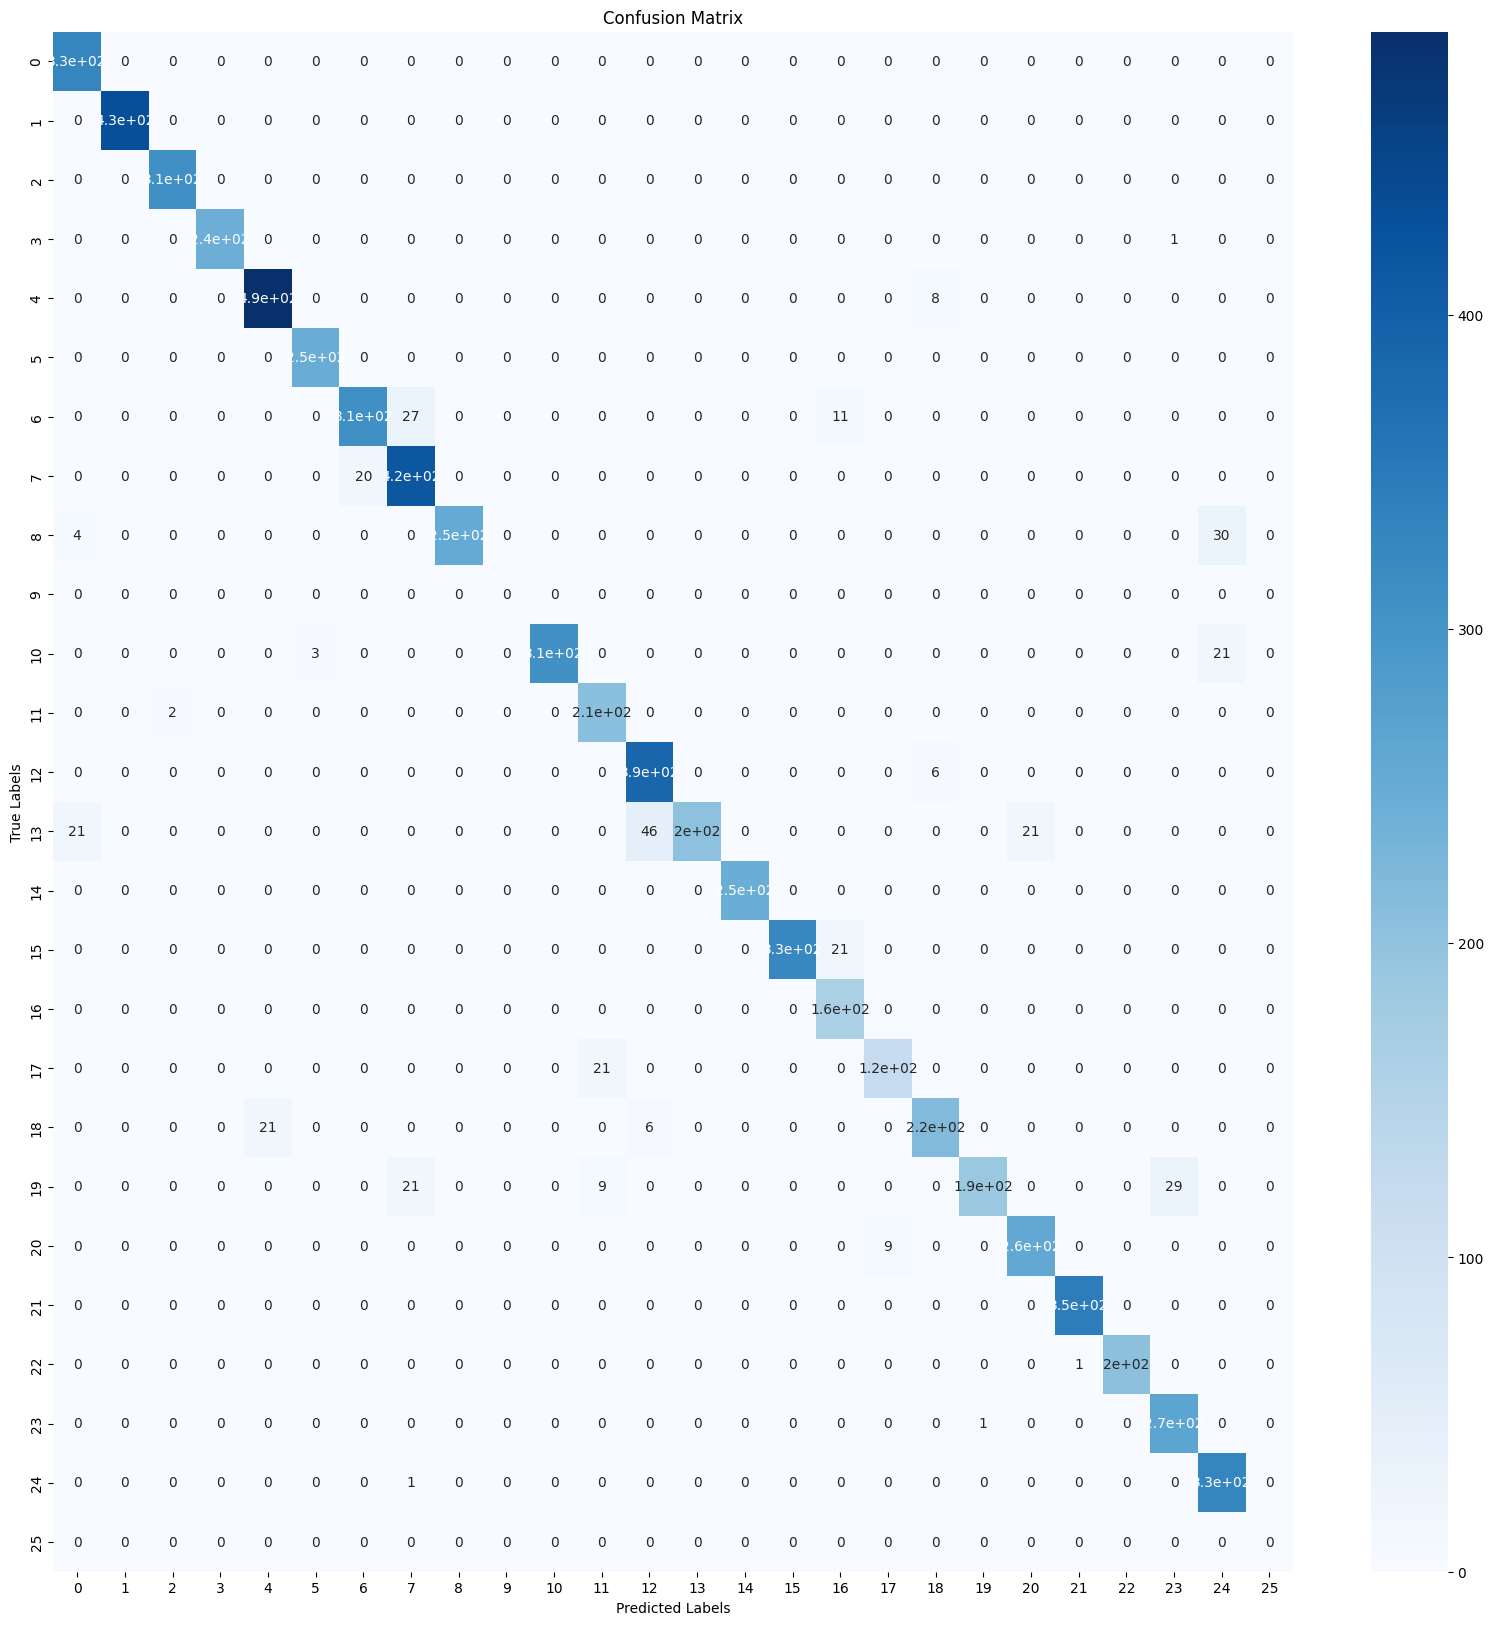

In [130]:
#load in confusion matrix to see what the model confuses the most

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions
preds, labels = get_predictions(model, test_loader)

# Compute confusion matrix
conf_mat = confusion_matrix(labels, preds)

row_index = 9
col_index = 9

# Insert an empty row
empty_row = np.zeros(conf_mat.shape[1])
arr_with_row = np.insert(conf_mat, row_index, empty_row, axis=0)

# Insert an empty column
empty_col = np.zeros(arr_with_row.shape[0])
conf_mat = np.insert(arr_with_row, col_index, empty_col, axis=1)

row_index = 25
col_index = 25

# Insert an empty row
empty_row = np.zeros(conf_mat.shape[1])
arr_with_row = np.insert(conf_mat, row_index, empty_row, axis=0)

# Insert an empty column
empty_col = np.zeros(arr_with_row.shape[0])
conf_mat = np.insert(arr_with_row, col_index, empty_col, axis=1)

# Plot confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat, annot=True, cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [114]:
index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
                   9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q',
                   17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
                   25: 'Z'}


# picking the ones with the highest confusion - above 25
true_to_common_confusion = [(6,7), # also (7, 6)
                            # (6,16), 
                            (8,24), 
                            # (10,24), 
                            # (13, 0),
                            (13,12), 
                            # (13,20), 
                            # (15,16), 
                            # (17,11), 
                            # (18,4),
                            # (19,7), 
                            (19,23)]

In [115]:
classes_of_interest = [6,7,12,13,19,23,24]

# negative examples
test_df_0 = test_df.loc[test_df['label'] == 0]#.sample()
test_images_0 = test_df_0.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_0 = test_df_0['label'].values
test_np_0 = torch.from_numpy(test_images_0.reshape(test_images_0.shape[0],1,28,28))

test_df_15 = test_df.loc[test_df['label'] == 15]#.sample()
test_images_15 = test_df_15.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_15 = test_df_15['label'].values
test_np_15 = torch.from_numpy(test_images_15.reshape(test_images_15.shape[0],1,28,28))

test_df_22 = test_df.loc[test_df['label'] == 22]#.sample()
test_images_22 = test_df_22.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_22 = test_df_22['label'].values
test_np_22 = torch.from_numpy(test_images_22.reshape(test_images_22.shape[0],1,28,28))


# manifold examples
test_df_6 = test_df.loc[test_df['label'] == 6]#.sample()
test_images_6 = test_df_6.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_6 = test_df_6['label'].values
test_np_6 = torch.from_numpy(test_images_6.reshape(test_images_6.shape[0],1,28,28))

test_df_7 = test_df.loc[test_df['label'] == 7]#.sample()
test_images_7 = test_df_7.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_7 = test_df_7['label'].values
test_np_7 = torch.from_numpy(test_images_7.reshape(test_images_7.shape[0],1,28,28))

test_df_8 = test_df.loc[test_df['label'] == 8]#.sample()
test_images_8 = test_df_8.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_8 = test_df_8['label'].values
test_np_8 = torch.from_numpy(test_images_8.reshape(test_images_8.shape[0],1,28,28))

test_df_12 = test_df.loc[test_df['label'] == 12]#.sample()
test_images_12 = test_df_12.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_12 = test_df_12['label'].values
test_np_12 = torch.from_numpy(test_images_12.reshape(test_images_12.shape[0],1,28,28))


test_df_13 = test_df.loc[test_df['label'] == 13]#.sample()
test_images_13 = test_df_13.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_13 = test_df_13['label'].values
test_np_13 = torch.from_numpy(test_images_13.reshape(test_images_13.shape[0],1,28,28))


test_df_19 = test_df.loc[test_df['label'] == 19]#.sample()
test_images_19 = test_df_19.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_19 = test_df_19['label'].values
test_np_19 = torch.from_numpy(test_images_19.reshape(test_images_19.shape[0],1,28,28))


test_df_23 = test_df.loc[test_df['label'] == 23]#.sample()
test_images_23 = test_df_23.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_23 = test_df_23['label'].values
test_np_23 = torch.from_numpy(test_images_23.reshape(test_images_23.shape[0],1,28,28))


test_df_24 =  test_df.loc[test_df['label'] == 24]#.sample()
test_images_24 = test_df_24.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels_24 = test_df_24['label'].values
test_np_24 = torch.from_numpy(test_images_24.reshape(test_images_24.shape[0],1,28,28))





In [116]:
model.eval()  # Set the model to evaluation mode

# Define the hook function to capture activations
all_activations = {}
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

hook = model.fc1.register_forward_hook(get_activation('fc1'))

#get model activations for all the negative and postive examples we want to pull
output = model(test_np_6)
all_activations[6] = activations['fc1']

output = model(test_np_7)
all_activations[7] = activations['fc1']

output = model(test_np_8)
all_activations[8] = activations['fc1']

output = model(test_np_12)
all_activations[12] = activations['fc1']

output = model(test_np_13)
all_activations[13] = activations['fc1']

output = model(test_np_19)
all_activations[19] = activations['fc1']

output = model(test_np_23)
all_activations[23] = activations['fc1']

output = model(test_np_24)
all_activations[24] = activations['fc1']

output = model(test_np_0)
all_activations[0] = activations['fc1']

output = model(test_np_15)
all_activations[15] = activations['fc1']

output = model(test_np_22)
all_activations[22] = activations['fc1']

# Unregister the hook
hook.remove()
# print(all_activations)

{6: tensor([[ 2.2576e+00, -1.1328e-13, -1.1298e-09,  ..., -1.3324e+00,
         -5.1596e-03, -8.9943e-08],
        [ 3.3904e+00, -1.1846e-13, -1.1620e-09,  ..., -2.1396e+00,
         -7.7644e-03, -1.0005e-07],
        [ 3.7074e+00, -1.1301e-13, -1.1512e-09,  ..., -2.3651e+00,
         -8.0452e-03, -9.9653e-08],
        ...,
        [ 4.3931e+00, -9.3648e-14, -1.2649e-09,  ..., -9.6919e-01,
         -5.2462e-03, -9.8708e-08],
        [ 1.5277e+00, -1.4382e-13, -1.2318e-09,  ..., -1.3560e+00,
         -7.6028e-03, -1.1232e-07],
        [ 2.3283e+00, -1.3678e-13, -1.5998e-09,  ..., -1.2129e+00,
         -6.4187e-03, -1.1337e-07]]), 7: tensor([[-1.9530e+00, -1.0950e-13, -1.5924e-09,  ..., -1.4468e+00,
         -7.6783e-03, -1.2338e-07],
        [-1.2554e+00, -6.1986e-14, -1.0566e-09,  ..., -1.5502e+00,
         -5.8236e-03, -8.2411e-08],
        [ 2.5420e+00, -1.4205e-13, -1.1477e-09,  ..., -1.6447e+00,
         -6.2872e-03, -1.0547e-07],
        ...,
        [ 2.7462e-01, -1.7483e-13, -2.

In [117]:

#format the activations to run PCA
formatted_activations = torch.cat([all_activations[key] for key in all_activations], dim=0)

labels_activations = torch.cat([key*torch.ones(all_activations[key].size(0)) for key in all_activations])


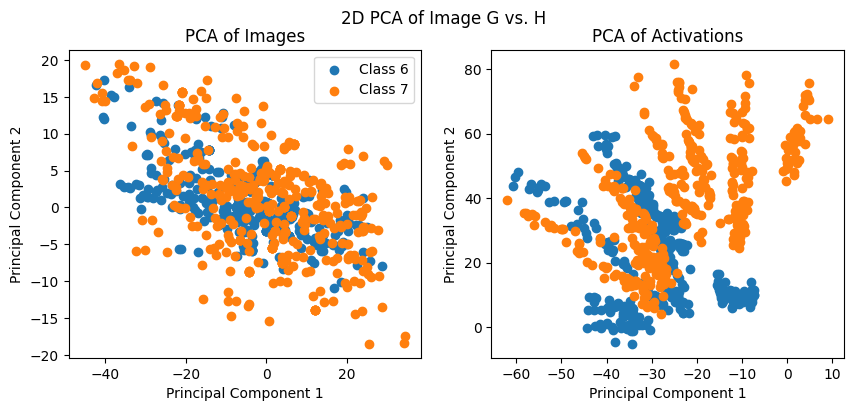

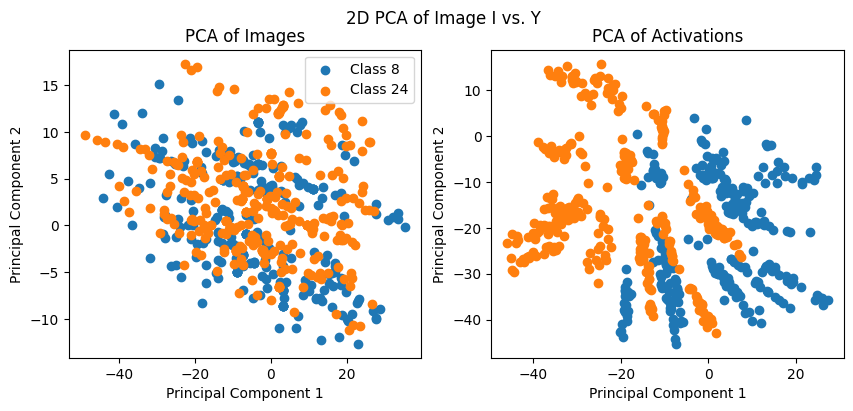

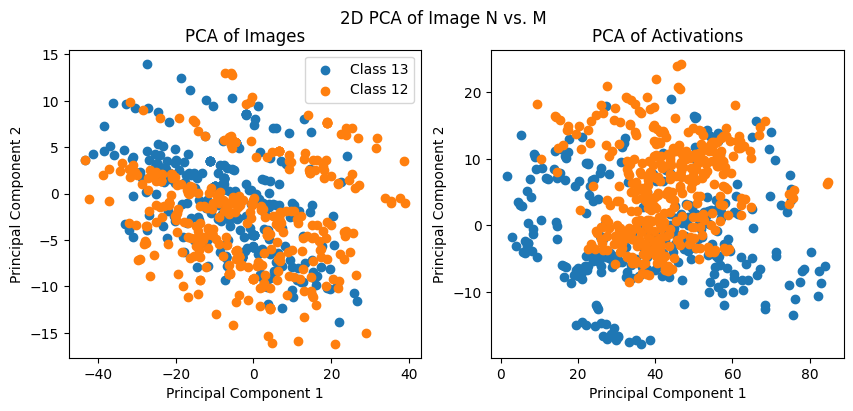

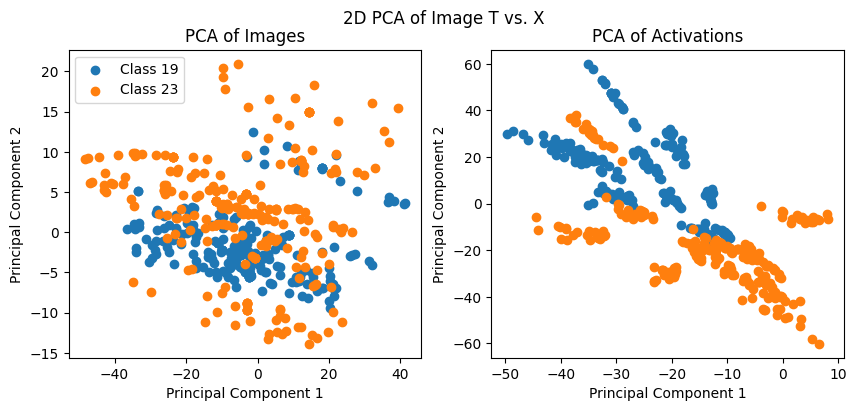

In [126]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)
activations_pca = pca.fit_transform(formatted_activations)

# Visualization
for pair in true_to_common_confusion:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i, target in enumerate(pair):
        ax[0].scatter(principal_components[y == target, 0], 
                    principal_components[y == target, 1], 
                    label=f"Class {target}")
        ax[1].scatter(activations_pca[labels_activations == target, 0], 
                    activations_pca[labels_activations == target, 1], 
                    label=f"Class {target}")

    ax[0].legend()
    ax[0].set_xlabel("Principal Component 1")
    ax[0].set_ylabel("Principal Component 2")
    ax[0].set_title('PCA of Images')
    ax[1].set_xlabel("Principal Component 1")
    ax[1].set_ylabel("Principal Component 2")
    ax[1].set_title('PCA of Activations')
    fig.suptitle(f"2D PCA of Image {index_to_letter[pair[0]]} vs. {index_to_letter[pair[1]]}")
    plt.show()

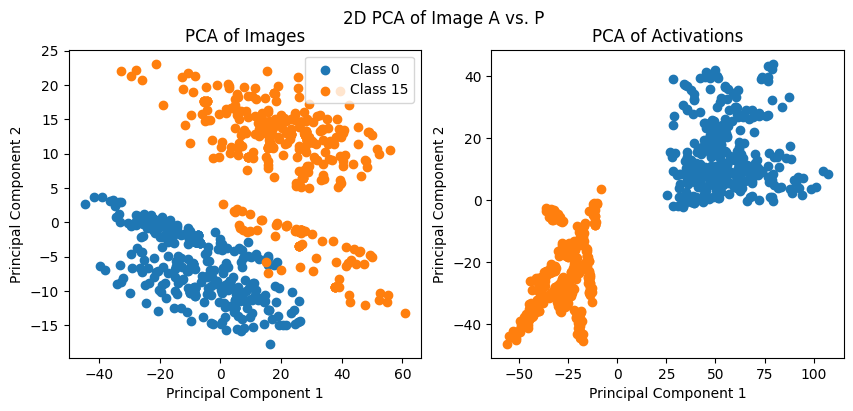

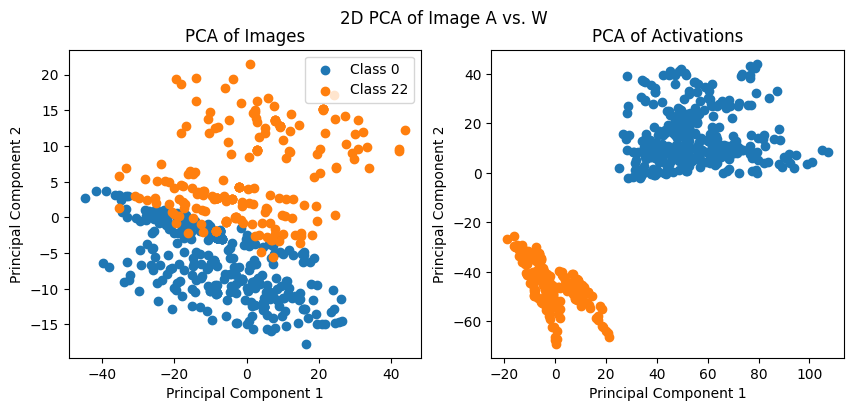

In [131]:
negative_examples = [(0,15),
                     (0,22)]

for pair in negative_examples:    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i, target in enumerate(pair):
        ax[0].scatter(principal_components[y == target, 0], 
                    principal_components[y == target, 1], 
                    label=f"Class {target}")
        ax[1].scatter(activations_pca[labels_activations == target, 0], 
                    activations_pca[labels_activations == target, 1], 
                    label=f"Class {target}")

    ax[0].legend()
    ax[0].set_xlabel("Principal Component 1")
    ax[0].set_ylabel("Principal Component 2")
    ax[0].set_title('PCA of Images')
    ax[1].set_xlabel("Principal Component 1")
    ax[1].set_ylabel("Principal Component 2")
    ax[1].set_title('PCA of Activations')
    fig.suptitle(f"2D PCA of Image {index_to_letter[pair[0]]} vs. {index_to_letter[pair[1]]}")
    plt.show()

